# Install and import dependences

In [ ]:
#!pip install --upgrade python-binance tensorflow

In [1]:
from binance.client import Client
from binance import BinanceSocketManager
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, confusion_matrix

# Load data

In [2]:
api_key = "imuSkmeAI4PpxNERZRcnzx6nEkReEhuLedZphxZNphhnUPLR4QH61aXfjnBqUtfH"
api_secret = "56AvdFdOWWoRF20rh6Knq8awDYM145luMDH0XvDMkSD6nffbRwYTCrsxwJmyVLK1"
client = Client(api_key, api_secret)

In [3]:
#Get the exchange info, which contains information about all trading pairs
exchange_info = client.get_exchange_info()

#Extract the symbols of all trading pairs
symbols = [symbol['symbol'] for symbol in exchange_info['symbols'] if "BRL" in symbol['symbol']]

#Filter out only the base cryptocurrencies (e.g., BTC, ETH)
symbols = list(symbol.split(' ')[0] for symbol in symbols)

In [4]:
# Function to fetch historical cryptocurrency data
def fetch_binance_cryptocurrency_data(symbol, start_date, end_date, interval='1d'):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)

    # Convert data to a Pandas DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

database = {}
present_day = dt.date.today()
start_date = '1900-01-01'
end_date = f"{present_day}"
for ticker in symbols:
    data = fetch_binance_cryptocurrency_data(ticker, start_date, end_date)
    database[ticker] = data.close.values.astype(float)

In [ ]:
# Save data to CSV
for ticker, data in database.items():
    filename = f"{ticker}_data.csv"
    data.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Functions

Model functions

In [59]:
def model_1(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(8, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [60]:
def model_2(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(8, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2

In [61]:
def model_3(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(8, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=True),
        SimpleRNN(8, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [62]:
def model_4(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(4, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [63]:
def model_5(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(4, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(4, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [64]:
def model_6(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(4, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(4, activation='relu', return_sequences=True),
        SimpleRNN(4, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [86]:
def model_7(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(2, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [66]:
def model_8(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(2, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(2, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [67]:
def model_9(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(2, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(2, activation='relu', return_sequences=True),
        SimpleRNN(2, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [68]:
def model_10(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(1, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [69]:
def model_11(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(1, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(1, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [70]:
def model_12(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(1, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(1, activation='relu', return_sequences=True),
        SimpleRNN(1, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

Other functions

In [84]:
# Suppress the warning related to TensorFlow tracing
tf.autograph.set_verbosity(0)

def pred_eval(model_function, lb_list: list = [11], epochs: int = 100, ticker_list: list = symbols, print_info: bool = True):
    buy_list = []
    total_loss = 0
    total_sold = 0
    for lb in lb_list:
        pred_status_list, true_status_list = [], []
        last_price_list = []
        pred_1_list, pred_2_list = [], []
        count = 0
        total_last_stock_price, total_gamble_stock_price = 0, 0
        total_pred_stock_price, total_true_stock_price = 0, 0
        total_proft = 0

        for ticker in ticker_list:
            count += 1
            price = database[ticker]
            act_status, last_price, pred1, pred2, true_price1, true_price2, loss = model_function(price, look_back = lb, epochs=epochs, ticker=ticker, plot_graph = False)
            
            pred_status_list.append(act_status)
            last_price_list.append(last_price)
            pred_1_list.append(pred1)
            pred_2_list.append(pred2)
            total_loss += loss

            my_act_status = act_status
            my_gamble = sell_price(last_price, pred1, pred2)
            gamble_proft = my_gamble/last_price
            sold_status = check_sold(my_gamble, true_price1)

            if my_gamble/last_price < 1.001 and my_act_status == True: 
                my_act_status = False
            if my_act_status == False: 
                sold_status = None
                gamble_proft = None
            if sold_status:
                total_sold += 1
            

            if print_info:
                print('{:<2} '.format(count), 
                      '{:<8} -'.format(ticker), 
                      'LastPrice: {:<10}'.format(round(float(last_price), 3)), 
                      '/ Pred1: {:<10}'.format(round(float(pred1), 3)), 
                      '/ Pred2: {:<10}'.format(round(float(pred2), 3)), 
                      '/ TruePrice1: {:<10}'.format(round(float(true_price1), 3)), 
                      '/ TruePrice2: {:<10}'.format(round(float(true_price2), 3)), 
                      '|| ActStatus: {:<1}'.format(act_status), 
                      '/ MyActStatus: {:<1}'.format(my_act_status), 
                      '/ SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''), 
                      '/ MyGamble: {:<10}'.format(round(float(my_gamble), 3)), 
                      '/ GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                      '/ TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                      '|| CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0)))
                            

            true_proft = true_price1 - last_price
            if act_status:
                total_last_stock_price += last_price
                total_pred_stock_price += pred1
                total_gamble_stock_price += my_gamble
                total_true_stock_price += true_price1
            if true_proft > 0:
                true_status_list.append(True)
            if true_proft <= 0:
                true_status_list.append(False)
                
            if act_status and my_act_status:
                buy = ['{:<8}'.format(ticker), 
                       'LastPrice: {:<10}'.format(round(float(last_price), 3)), 
                       'MyGamble: {:<10}'.format(round(float(my_gamble), 3)), 
                       'TruePrice: {:<10}'.format(round(float(true_price1), 3)),
                       'GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                       'TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                       'SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''),
                       'CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0))]
                buy_list.append(buy)
                      

        if not total_last_stock_price == 0:
            print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
            print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
            print('True proft %:', total_true_stock_price / total_last_stock_price)
        if total_last_stock_price == 0:
            print('\nAll False')

        print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', total_sold/len(buy_list), '\n')
        
        for i in buy_list:
            print(i)
    
        index = my_confusion_matrix(true_status_list, pred_status_list)
        print('Wrong Buy_Act List:')
        for i in index:
            print(symbols[i], '\n')

In [29]:
def my_confusion_matrix(true_status: list, pred_status: list):
    cm = confusion_matrix(true_status, pred_status)
    labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    cm = cm.reshape((2, 2))
    
    # Print indices where true and pred statuses are False and True respectively
    false_true_indices = []
    for i in range(len(true_status)):
        if true_status[i] == False and pred_status[i] == True:
            false_true_indices.append(i)
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print("CM accuracy:", accuracy)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return false_true_indices 

In [88]:
def sell_price(last_value, pred1, pred2, margin = 0.001):
    'Optmize the sell price'
    if pred1 <= last_value and abs(last_value - pred1) <= (pred1*0.0025):
        return last_value
    
    if (pred1 - (pred1*margin)) <= last_value:
        return last_value
    
    if pred2/pred1 >= 1.05:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 + (pred1 * margin) <= last_value * 1.02:
            return pred1 + (pred1 * margin)
        else:
            return last_value * 1.02
    
    if pred2/pred1 >= 1.01:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 <= last_value * 1.02:
            return pred1
        else: 
            return last_value * 1.02

    else:
        return pred1 - (pred1 * margin)

In [31]:
def check_sold(gamble, true_price, margin = 0.002):
    'Check if the gamble price was sold'
    return gamble <= true_price + (true_price * margin)

# Predictions & Evaluate

Loss: 10262092.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 347706.75  / Pred2: 345805.969 / TruePrice1: 344444.0   / TruePrice2: 348949.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 347359.043 / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 3.42560451827012e-05
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.04       / Pred2: 5.047      / TruePrice1: 5.042      / TruePrice2: 5.039      || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 34209.70703125
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19435.828  / Pred2: 19665.74   / TruePrice1: 19691.93   / TruePrice2: 19612.53   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 17713.3046875
4   BNBBRL   - LastPrice: 2449.0     / Pred1: 2477.249   / Pred2: 2477.321   / TruePrice1: 2463.0     / TruePrice2: 2665.0     || ActStatus: 

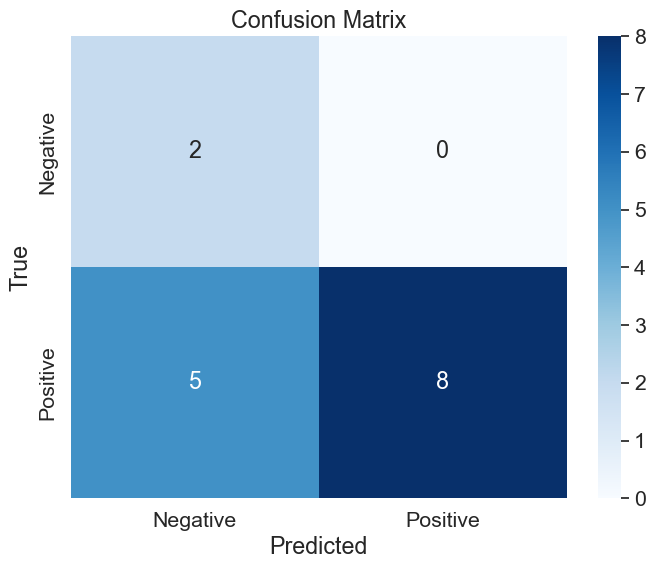

['BNBBRL', 'MyGamble: 2474.772  ', 'TruePrice: 2463.0    ', 'GambleProft: 1.011', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL', 'MyGamble: 4.998     ', 'TruePrice: 4.977     ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL', 'MyGamble: 99.331    ', 'TruePrice: 100.73    ', 'GambleProft: 1.001', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL', 'MyGamble: 447.995   ', 'TruePrice: 456.6     ', 'GambleProft: 1.009', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL', 'MyGamble: 0.834     ', 'TruePrice: 0.902     ', 'GambleProft: 1.006', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL', 'MyGamble: 0.794     ', 'TruePrice: 0.781     ', 'GambleProft: 1.028', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.073', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
Loss: 318537.3125
1   BTCBRL   

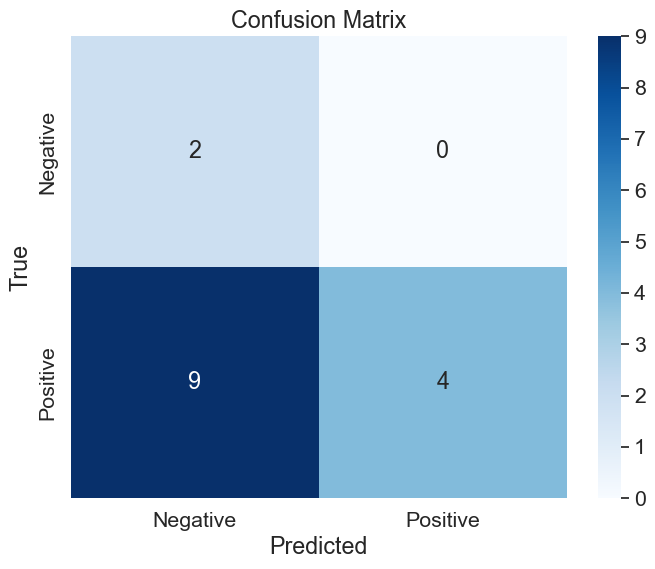

['BTCBRL', 'MyGamble: 344078.25 ', 'TruePrice: 344444.0  ', 'GambleProft: 1.003', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['ETHBRL', 'MyGamble: 19600.995 ', 'TruePrice: 19691.93  ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL', 'MyGamble: 3.653     ', 'TruePrice: 3.74      ', 'GambleProft: 1.004', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
Loss: 176503040.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 331380.25  / Pred2: 335445.5   / TruePrice1: 344444.0   / TruePrice2: 348949.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.0003296590584795922
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.052      / Pred2: 5.063      / TruePrice1: 5.042      / TruePrice2: 5.039      || ActStatus: 1 / MyActStatus: 1 / SoldStatus: 1 / MyGamble: 5.047      / GambleProft: 1.002 / TrueProft: 1.001 || CorrectModel: 1
Loss: 18753.662109375
3 

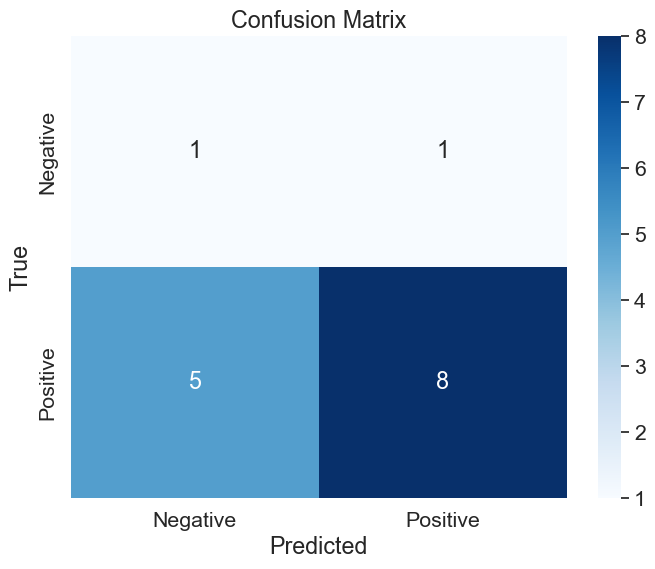

DOTBRL 

['USDTBRL', 'MyGamble: 5.047     ', 'TruePrice: 5.042     ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2463.475  ', 'TruePrice: 2463.0    ', 'GambleProft: 1.006', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL', 'MyGamble: 4.999     ', 'TruePrice: 4.977     ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL', 'MyGamble: 3.153     ', 'TruePrice: 3.125     ', 'GambleProft: 1.01 ', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL', 'MyGamble: 100.74    ', 'TruePrice: 100.73    ', 'GambleProft: 1.016', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL', 'MyGamble: 0.831     ', 'TruePrice: 0.902     ', 'GambleProft: 1.003', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL', 'MyGamble: 3.697     ', 'TruePrice: 3.74      ', 'GambleProft: 1.016', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']


In [14]:
for i in range(3):
    pred_eval(model_1, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 9445373.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 340135.844 / Pred2: 349523.688 / TruePrice1: 344444.0   / TruePrice2: 348949.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.0029880355577915907
2   USDTBRL  - LastPrice: 5.036      / Pred1: 4.98       / Pred2: 4.992      / TruePrice1: 5.042      / TruePrice2: 5.039      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 195682.546875
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19128.742  / Pred2: 19340.16   / TruePrice1: 19691.93   / TruePrice2: 19612.53   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 18561.8984375
4   BNBBRL   - LastPrice: 2449.0     / Pred1: 2432.282   / Pred2: 2474.789   / TruePrice1: 2463.0     / TruePrice2: 2665.0     || ActStatus: 0

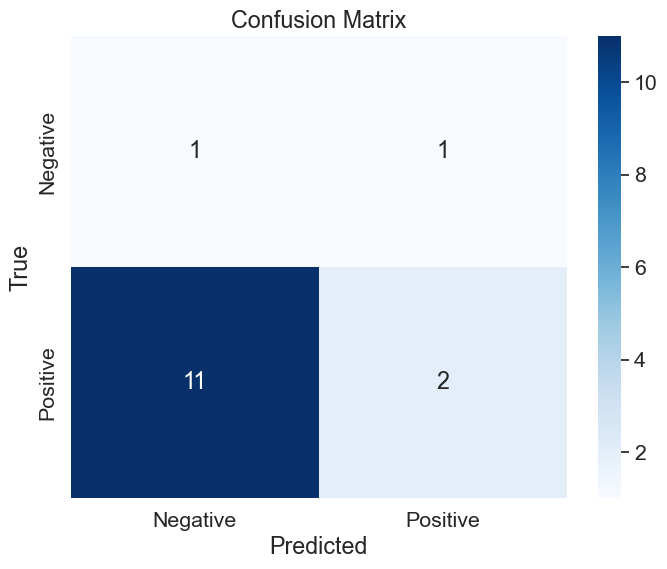

DOTBRL 

['LINKBRL', 'MyGamble: 100.027   ', 'TruePrice: 100.73    ', 'GambleProft: 1.008', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL', 'MyGamble: 53.949    ', 'TruePrice: 52.91     ', 'GambleProft: 1.006', 'TrueProft: 0.987', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
Loss: 20405012.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 343070.656 / Pred2: 342710.094 / TruePrice1: 344444.0   / TruePrice2: 348949.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.0012706697452813387
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.0        / Pred2: 5.012      / TruePrice1: 5.042      / TruePrice2: 5.039      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 28694.011

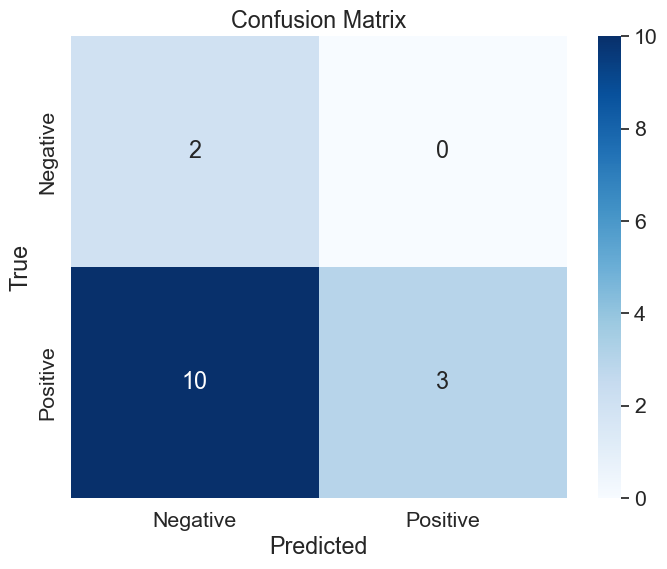

['DOGEBRL', 'MyGamble: 0.834     ', 'TruePrice: 0.902     ', 'GambleProft: 1.006', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.419', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
Loss: 28185316.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 339568.688 / Pred2: 343239.219 / TruePrice1: 344444.0   / TruePrice2: 348949.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.0010578599758446217
2   USDTBRL  - LastPrice: 5.036      / Pred1: 5.014      / Pred2: 5.003      / TruePrice1: 5.042      / TruePrice2: 5.039      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 68493.96875
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19321.846  / Pred2: 19607.451  / TruePrice1: 19691.93   / TruePrice2: 19612.53   || ActStatus: 0 /

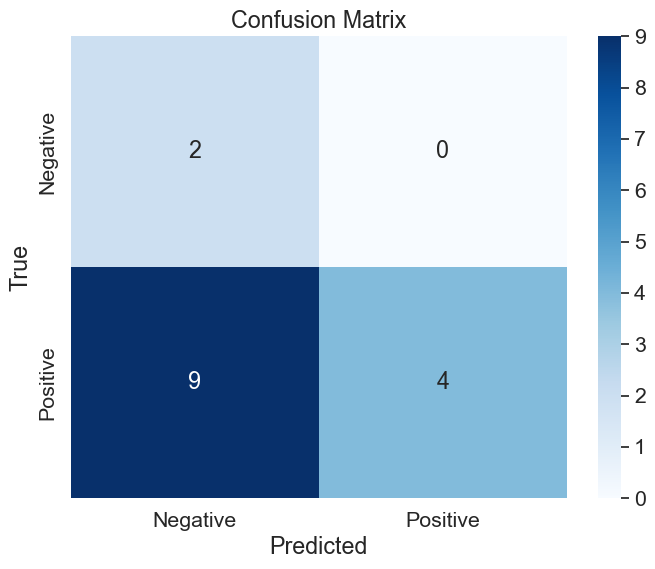

['BNBBRL', 'MyGamble: 2474.714  ', 'TruePrice: 2463.0    ', 'GambleProft: 1.01 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL', 'MyGamble: 100.68    ', 'TruePrice: 100.73    ', 'GambleProft: 1.015', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL', 'MyGamble: 0.845     ', 'TruePrice: 0.902     ', 'GambleProft: 1.02 ', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL', 'MyGamble: 3.672     ', 'TruePrice: 3.74      ', 'GambleProft: 1.009', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']


In [15]:
for i in range(3):
    pred_eval(model_2, epochs = 100, lb_list = [11], ticker_list = symbols[:15])

Loss: 74767584.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 336540.281 / Pred2: 339618.062 / TruePrice1: 344444.0   / TruePrice2: 348949.0   || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 343050.0   / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 0.0023874319158494473
2   USDTBRL  - LastPrice: 5.036      / Pred1: 4.992      / Pred2: 4.992      / TruePrice1: 5.042      / TruePrice2: 5.039      || ActStatus: 0 / MyActStatus: 0 / SoldStatus:   / MyGamble: 5.036      / GambleProft:       / TrueProft:       || CorrectModel: 0
Loss: 84333.7890625
3   ETHBRL   - LastPrice: 19556.48   / Pred1: 19515.076  / Pred2: 19983.191  / TruePrice1: 19691.93   / TruePrice2: 19612.53   || ActStatus: 1 / MyActStatus: 0 / SoldStatus:   / MyGamble: 19556.48   / GambleProft:       / TrueProft:       || CorrectModel: 1
Loss: 12200.478515625
4   BNBBRL   - LastPrice: 2449.0     / Pred1: 2501.742   / Pred2: 2513.673   / TruePrice1: 2463.0     / TruePrice2: 2665.0     || ActStatus

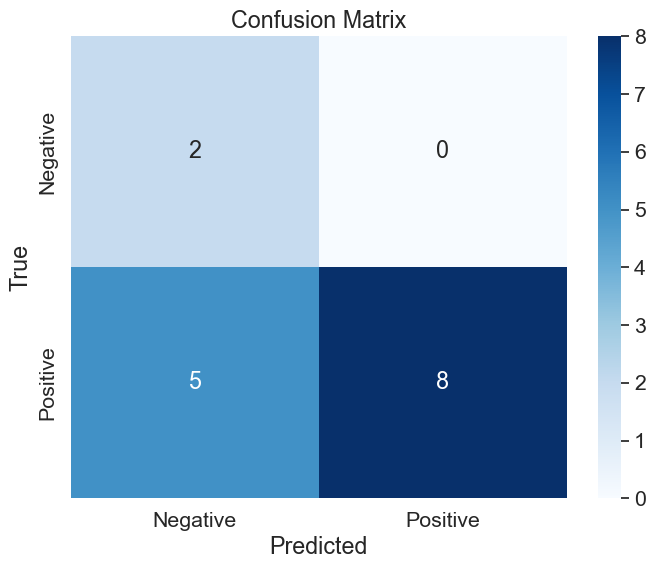

['BNBBRL', 'MyGamble: 2499.24   ', 'TruePrice: 2463.0    ', 'GambleProft: 1.021', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL', 'MyGamble: 101.174   ', 'TruePrice: 100.73    ', 'GambleProft: 1.02 ', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['DOGEBRL', 'MyGamble: 0.833     ', 'TruePrice: 0.902     ', 'GambleProft: 1.005', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL', 'MyGamble: 0.788     ', 'TruePrice: 0.781     ', 'GambleProft: 1.02 ', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.448', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
Loss: 33636648.0
1   BTCBRL   - LastPrice: 343050.0   / Pred1: 341431.844 / Pred2: 341320.094 / TruePrice1: 344444.0   / TruePrice2: 348949.0   || ActStatus: 0 / MyActSta

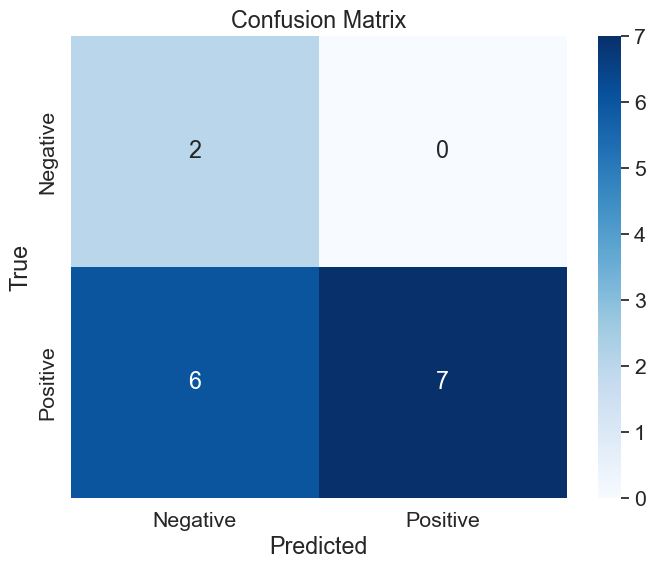

['ETHBRL', 'MyGamble: 19653.4   ', 'TruePrice: 19691.93  ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL', 'MyGamble: 2453.706  ', 'TruePrice: 2463.0    ', 'GambleProft: 1.002', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL', 'MyGamble: 3.161     ', 'TruePrice: 3.125     ', 'GambleProft: 1.013', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL', 'MyGamble: 101.174   ', 'TruePrice: 100.73    ', 'GambleProft: 1.02 ', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['DOGEBRL', 'MyGamble: 0.845     ', 'TruePrice: 0.902     ', 'GambleProft: 1.02 ', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL', 'MyGamble: 1.025     ', 'TruePrice: 0.781     ', 'GambleProft: 1.328', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.262', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
Loss: 262754176.0
1   BTCBRL   -

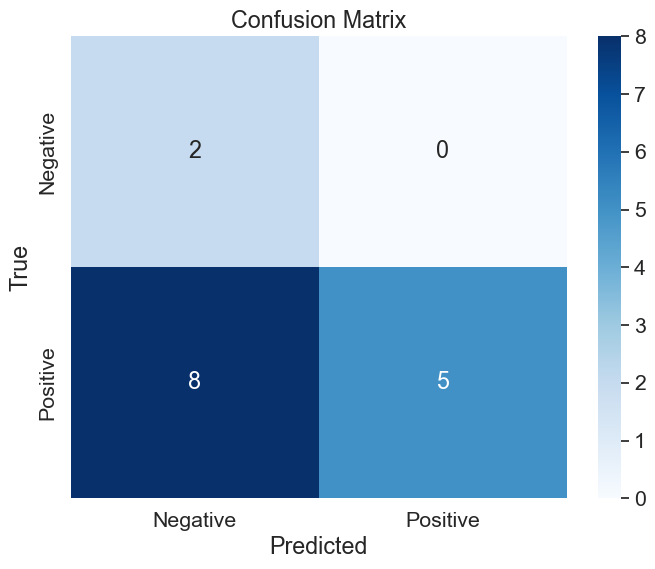

['ETHBRL', 'MyGamble: 19650.186 ', 'TruePrice: 19691.93  ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL', 'MyGamble: 5.0       ', 'TruePrice: 4.977     ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LTCBRL', 'MyGamble: 447.729   ', 'TruePrice: 456.6     ', 'GambleProft: 1.008', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL', 'MyGamble: 0.015     ', 'TruePrice: 0.015     ', 'GambleProft: 1.074', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']


In [16]:
for i in range(3):
    pred_eval(model_3, epochs = 100, lb_list = [11], ticker_list = symbols[:15])


Pred proft %: 1.0029475261512601
Gamble proft %: 1.00235731440125
True proft %: 1.0141764429638087

Look Back: 11 / Total Loss: 65837681.88167884 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.036     ', 'MyGamble: 5.044     ', 'TruePrice: 5.042     ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.023     ', 'TruePrice: 0.781     ', 'GambleProft: 1.325', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.325', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.5333333333333333


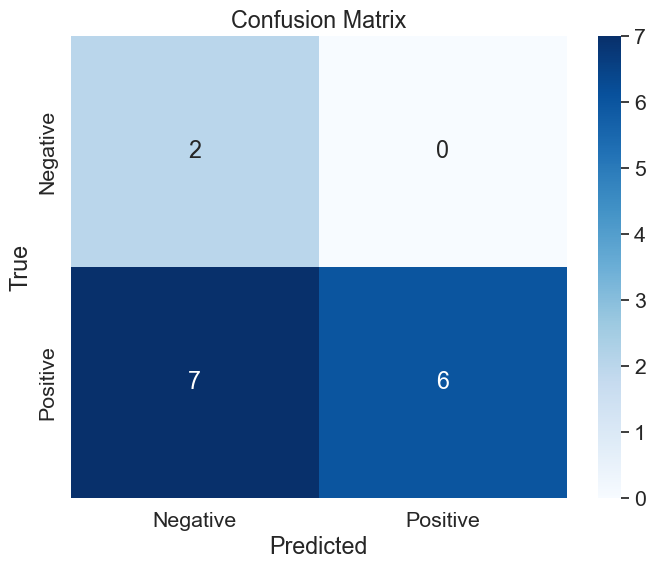


Pred proft %: 1.0009758697806193
Gamble proft %: 1.0013464782316972
True proft %: 1.006790313192388

Look Back: 11 / Total Loss: 139450759.21658167 / Sold Portion: 0.2 

['BNBBRL  ', 'LastPrice: 2449.0    ', 'MyGamble: 2478.361  ', 'TruePrice: 2463.0    ', 'GambleProft: 1.012', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.973     ', 'MyGamble: 4.993     ', 'TruePrice: 4.977     ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.023     ', 'TruePrice: 0.781     ', 'GambleProft: 1.324', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.41 ', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.002', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
CM a

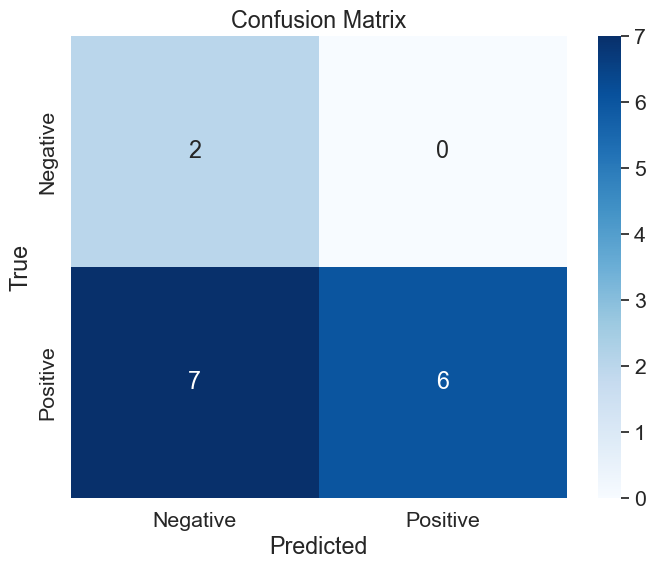


Pred proft %: 1.0025736503522384
Gamble proft %: 1.0015711154463867
True proft %: 1.004063769918574

Look Back: 11 / Total Loss: 390224655.44307315 / Sold Portion: 0.6666666666666666 

['BTCBRL  ', 'LastPrice: 343050.0  ', 'MyGamble: 343588.973', 'TruePrice: 344444.0  ', 'GambleProft: 1.002', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.973     ', 'MyGamble: 4.985     ', 'TruePrice: 4.977     ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.315', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4666666666666667


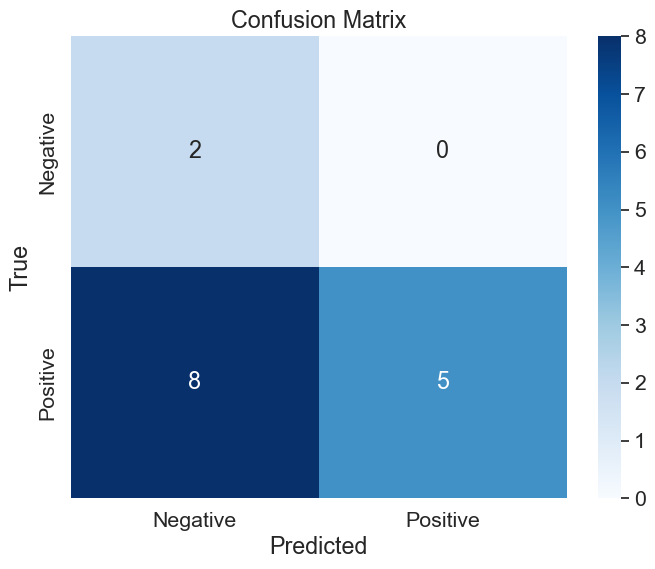

In [74]:
for i in range(3):
    pred_eval(model_4, epochs = 100, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.2568543396621898
Gamble proft %: 1.2555974853225276
True proft %: 0.9849074393774403

Look Back: 11 / Total Loss: 84370171.42903338 / Sold Portion: 0.0 

['XRPBRL  ', 'LastPrice: 3.122     ', 'MyGamble: 3.155     ', 'TruePrice: 3.125     ', 'GambleProft: 1.011', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.497     ', 'TruePrice: 1.31      ', 'GambleProft: 1.807', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.021     ', 'TruePrice: 0.015     ', 'GambleProft: 1.459', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.2


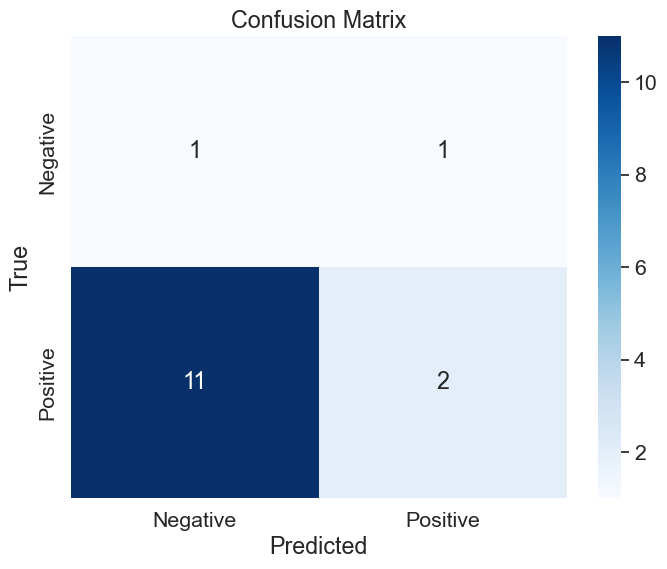

ENJBRL 


Pred proft %: 1.0086694837021772
Gamble proft %: 1.007660814218475
True proft %: 1.0139406020462012

Look Back: 11 / Total Loss: 429827808.58465743 / Sold Portion: 0.16666666666666666 

['USDTBRL ', 'LastPrice: 5.036     ', 'MyGamble: 5.057     ', 'TruePrice: 5.042     ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19     ', 'MyGamble: 99.613    ', 'TruePrice: 100.73    ', 'GambleProft: 1.004', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.023     ', 'TruePrice: 0.781     ', 'GambleProft: 1.325', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 1.495     ', 'TruePrice: 1.31      ', 'GambleProft: 1.082', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.021     ', 'TruePrice: 0.015     ', 'GambleProft: 1.46 ', 'TrueProft: 1.057', 'SoldStatus: 0'

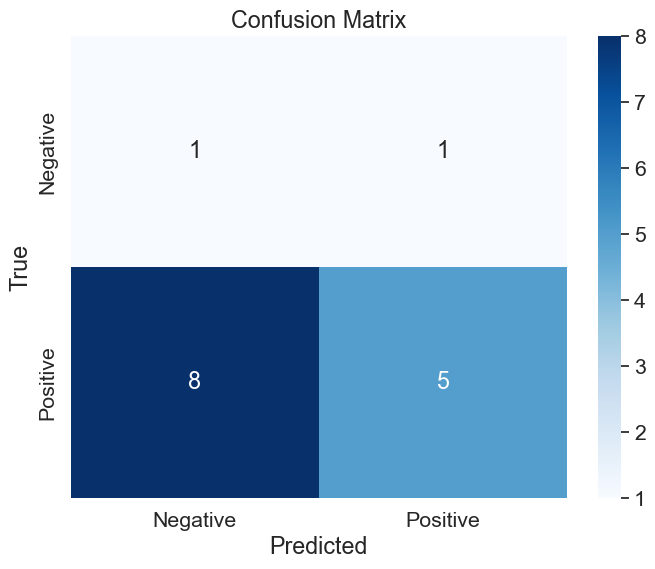

ENJBRL 


Pred proft %: 1.002838484506378
Gamble proft %: 1.002859846136725
True proft %: 1.0274095242318269

Look Back: 11 / Total Loss: 38355120.68015254 / Sold Portion: 0.2 

['XRPBRL  ', 'LastPrice: 3.122     ', 'MyGamble: 3.142     ', 'TruePrice: 3.125     ', 'GambleProft: 1.007', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 444.2     ', 'MyGamble: 445.228   ', 'TruePrice: 456.6     ', 'GambleProft: 1.002', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.024     ', 'TruePrice: 0.781     ', 'GambleProft: 1.325', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.446', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.196', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1

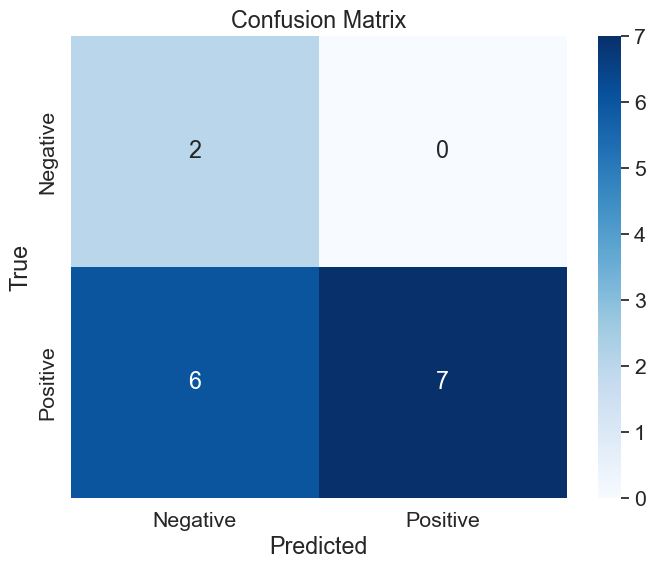

In [75]:
for i in range(3):
    pred_eval(model_5, epochs = 100, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.0001041593340476
Gamble proft %: 1.0007135047555502
True proft %: 1.0275909607871072

Look Back: 11 / Total Loss: 26186847.33239433 / Sold Portion: 0.2 

['BUSDBRL ', 'LastPrice: 4.973     ', 'MyGamble: 5.005     ', 'TruePrice: 4.977     ', 'GambleProft: 1.007', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638     ', 'MyGamble: 3.668     ', 'TruePrice: 3.74      ', 'GambleProft: 1.008', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.027     ', 'TruePrice: 0.781     ', 'GambleProft: 1.329', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.021     ', 'TruePrice: 0.015     ', 'GambleProft: 1.454', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.002     ', 'TruePrice: 0.001     ', 'GambleProft: 1.642', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM a

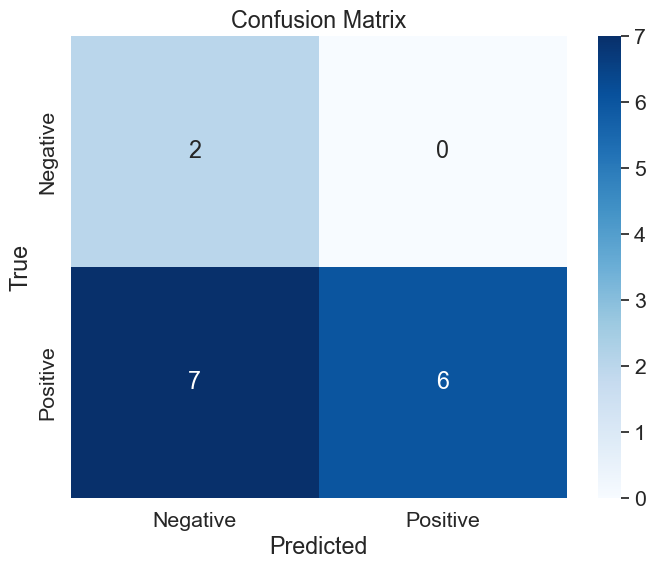


Pred proft %: 1.0419270004520993
Gamble proft %: 1.0430566637698582
True proft %: 1.0026129322338166

Look Back: 11 / Total Loss: 20639465.08319541 / Sold Portion: 0.3333333333333333 

['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.023     ', 'TruePrice: 0.781     ', 'GambleProft: 1.324', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.006', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.154', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4


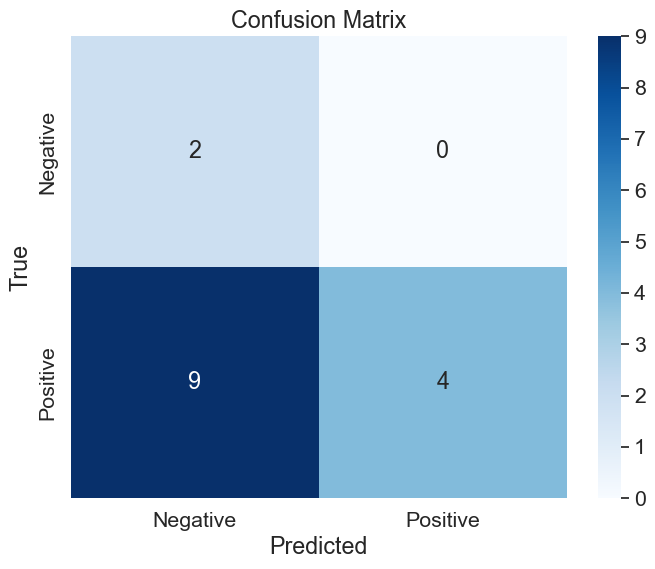


Pred proft %: 1.0051401350239297
Gamble proft %: 1.0051401270602813
True proft %: 1.0042177208789969

Look Back: 11 / Total Loss: 1923387.812531469 / Sold Portion: 0.5 

['BTCBRL  ', 'LastPrice: 343050.0  ', 'MyGamble: 344658.406', 'TruePrice: 344444.0  ', 'GambleProft: 1.005', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['ETHBRL  ', 'LastPrice: 19556.48  ', 'MyGamble: 19810.807 ', 'TruePrice: 19691.93  ', 'GambleProft: 1.013', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.499     ', 'TruePrice: 1.31      ', 'GambleProft: 1.809', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.26666666666666666


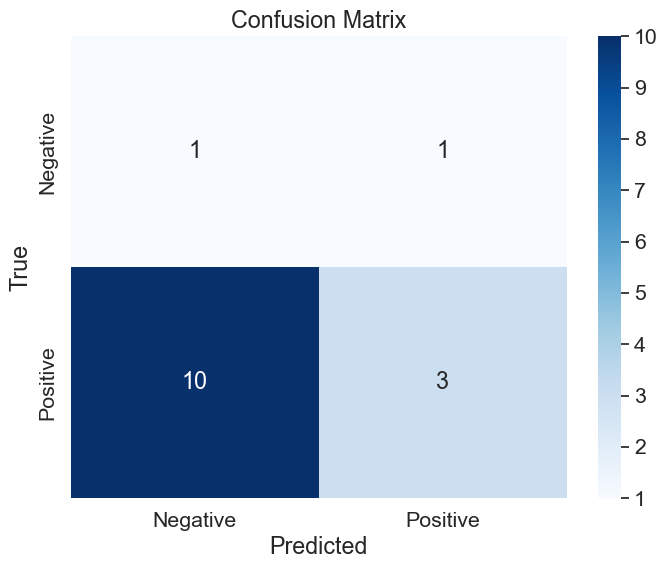

ENJBRL 



In [76]:
for i in range(3):
    pred_eval(model_6, epochs = 100, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.0038028760763082
Gamble proft %: 1.0029434778332604
True proft %: 1.0079325631743252

Look Back: 11 / Total Loss: 407166321.2450737 / Sold Portion: 0.6 

['BUSDBRL ', 'LastPrice: 4.973     ', 'MyGamble: 4.984     ', 'TruePrice: 4.977     ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.829     ', 'MyGamble: 0.84      ', 'TruePrice: 0.902     ', 'GambleProft: 1.014', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 0.775     ', 'TruePrice: 0.781     ', 'GambleProft: 1.003', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.416', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.002     ', 'TruePrice: 0.001     ', 'GambleProft: 1.706', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM a

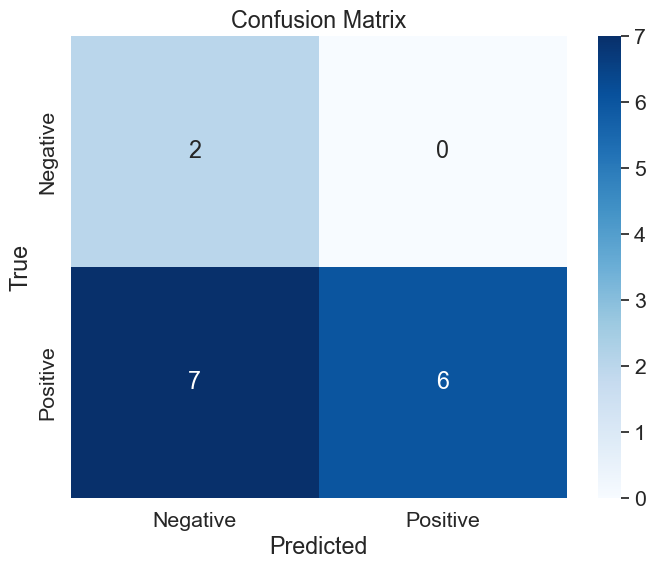

Wrong Buy_Act List:

Pred proft %: 0.9994008619095207
Gamble proft %: 1.0000018920411586
True proft %: 1.0040633366812222

Look Back: 11 / Total Loss: 13096691.713494016 / Sold Portion: 0.0 

['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.022     ', 'TruePrice: 0.781     ', 'GambleProft: 1.323', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 1.781     ', 'TruePrice: 1.31      ', 'GambleProft: 1.289', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.26666666666666666


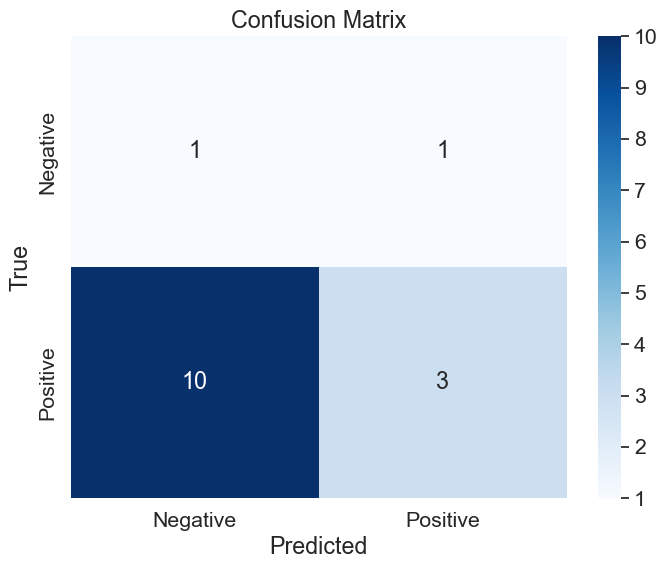

Wrong Buy_Act List:
ENJBRL 


Pred proft %: 1.0030063219232728
Gamble proft %: 1.0022665219967652
True proft %: 1.0107207018962374

Look Back: 11 / Total Loss: 120212967853.24406 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.036     ', 'MyGamble: 5.059     ', 'TruePrice: 5.042     ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122     ', 'MyGamble: 3.133     ', 'TruePrice: 3.125     ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.829     ', 'MyGamble: 0.83      ', 'TruePrice: 0.902     ', 'GambleProft: 1.002', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.5333333333333333


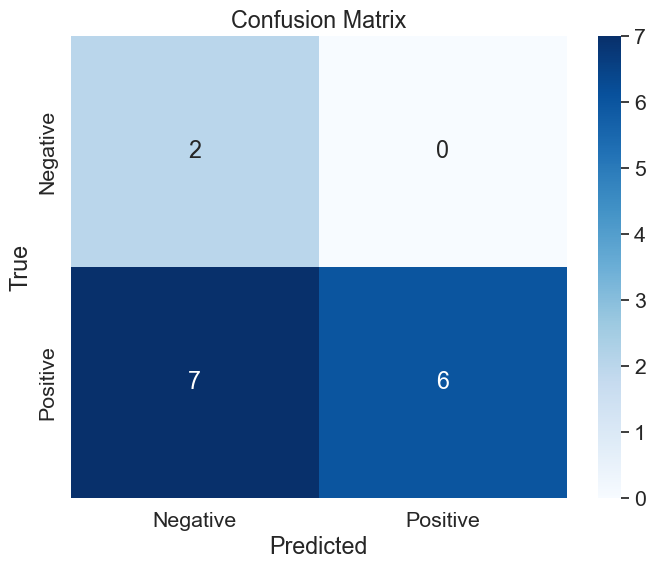

Wrong Buy_Act List:


In [89]:
for i in range(3):
    pred_eval(model_7, epochs = 100, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.0597297765012343
Gamble proft %: 1.0594934448144442
True proft %: 1.0251312231588992

Look Back: 11 / Total Loss: 871451580.6889529 / Sold Portion: 0.25 

['ADABRL  ', 'LastPrice: 3.638     ', 'MyGamble: 3.644     ', 'TruePrice: 3.74      ', 'GambleProft: 1.002', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.023     ', 'TruePrice: 0.781     ', 'GambleProft: 1.325', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.432', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.002     ', 'TruePrice: 0.001     ', 'GambleProft: 1.506', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4


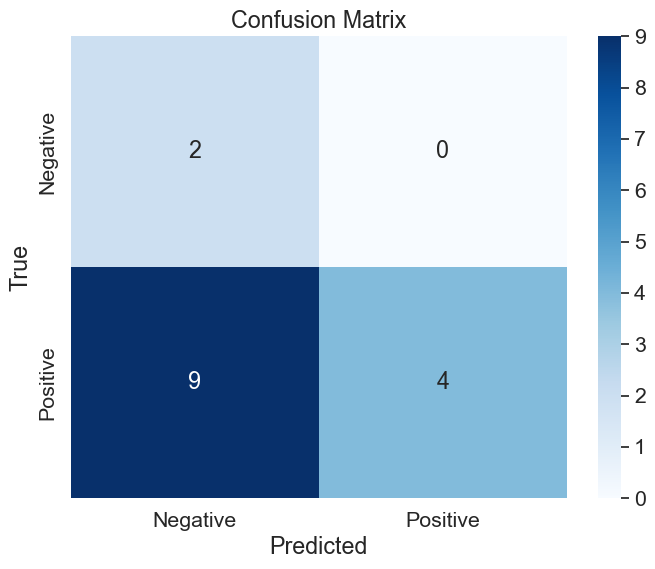


Pred proft %: 0.9991194222060467
Gamble proft %: 1.0000029380910493
True proft %: 1.0040633235304264

Look Back: 11 / Total Loss: 401370571.9500478 / Sold Portion: 0.5 

['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.39      ', 'TruePrice: 1.31      ', 'GambleProft: 1.729', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.011', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.2


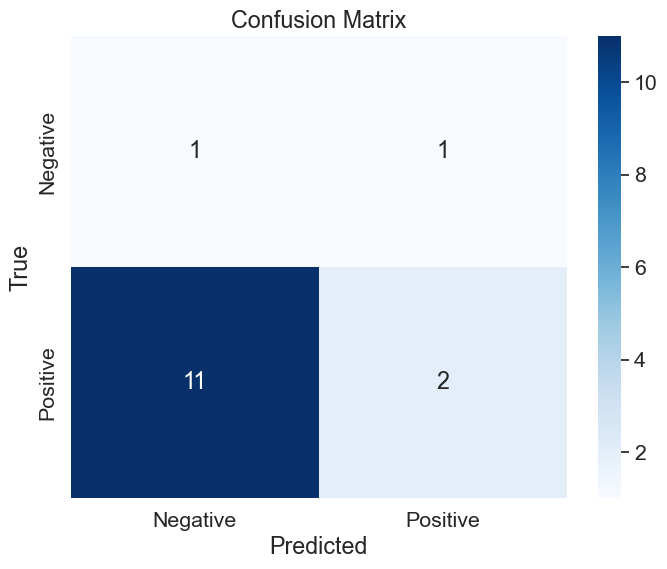

ENJBRL 


Pred proft %: 1.0016536543706467
Gamble proft %: 1.0025294087967458
True proft %: 1.015936008473982

Look Back: 11 / Total Loss: 120204638395.47119 / Sold Portion: 0.25 

['ADABRL  ', 'LastPrice: 3.638     ', 'MyGamble: 3.643     ', 'TruePrice: 3.74      ', 'GambleProft: 1.001', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.022     ', 'TruePrice: 0.781     ', 'GambleProft: 1.324', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.433', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.48 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4666666666666667


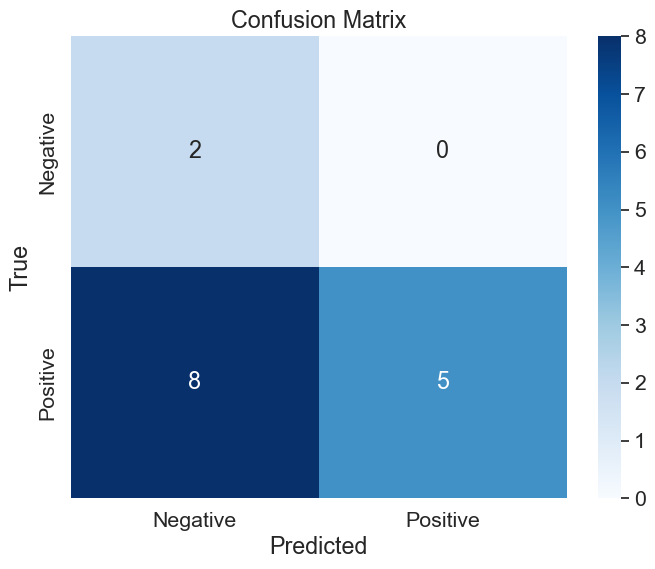

In [78]:
for i in range(3):
    pred_eval(model_8, epochs = 100, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.6339347461907945
Gamble proft %: 1.6323008114446038
True proft %: 0.9710434325453555

Look Back: 11 / Total Loss: 120587314915.93822 / Sold Portion: 0.0 

['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.023     ', 'TruePrice: 0.781     ', 'GambleProft: 1.324', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.496     ', 'TruePrice: 1.31      ', 'GambleProft: 1.806', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.43 ', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.2


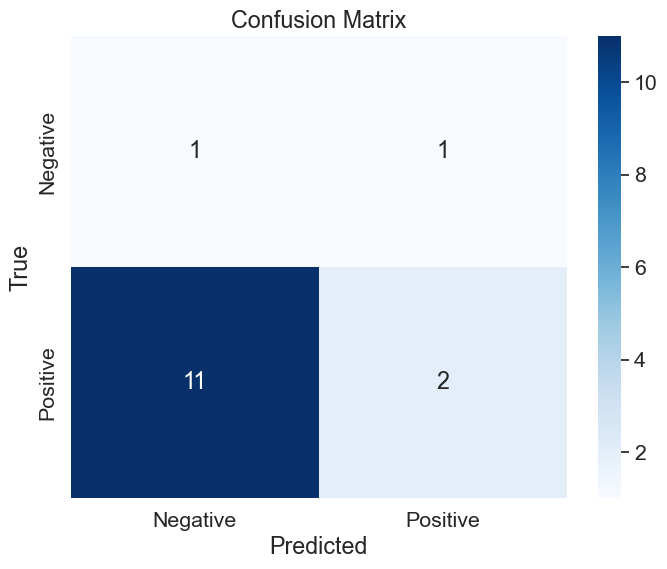

ENJBRL 


Pred proft %: 1.3277205208578327
Gamble proft %: 1.3263928003369747
True proft %: 1.0117043105242656

Look Back: 11 / Total Loss: 120587273433.14699 / Sold Portion: 0.0 

['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.023     ', 'TruePrice: 0.781     ', 'GambleProft: 1.325', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.427', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.231', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.3333333333333333


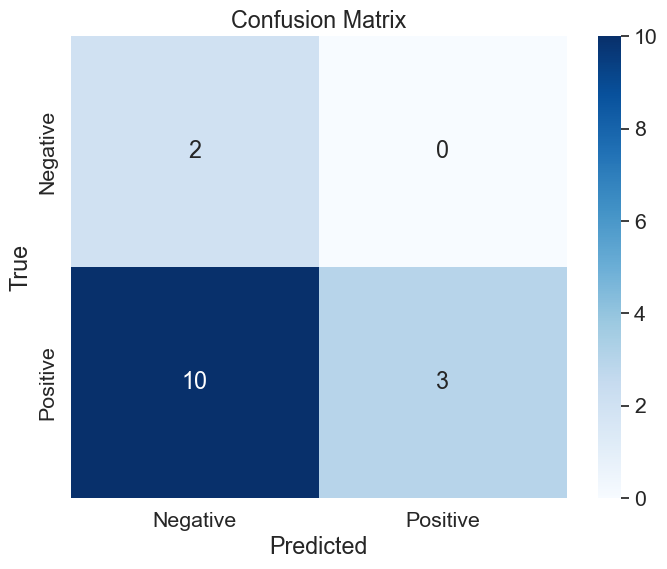


Pred proft %: 1.0032532779818657
Gamble proft %: 1.002250024703884
True proft %: 1.0040635497817305

Look Back: 11 / Total Loss: 399885257.6727889 / Sold Portion: 0.5 

['BTCBRL  ', 'LastPrice: 343050.0  ', 'MyGamble: 343821.865', 'TruePrice: 344444.0  ', 'GambleProft: 1.002', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.41 ', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.26666666666666666


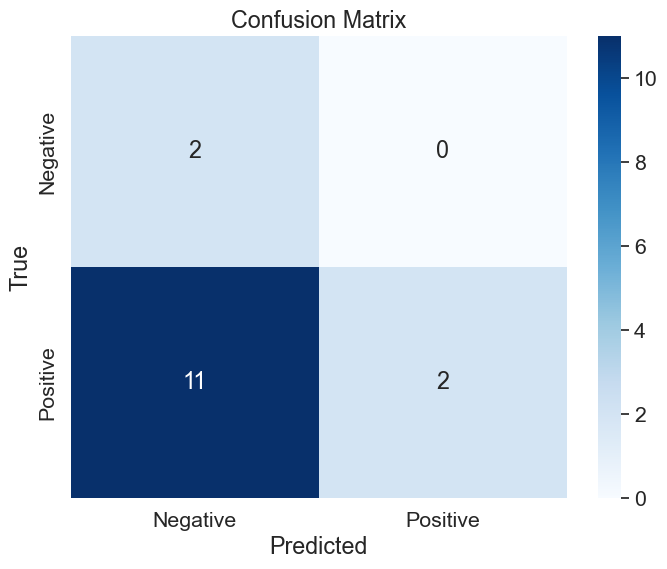

In [79]:
for i in range(3):
    pred_eval(model_9, epochs = 100, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.0011263266438806
Gamble proft %: 1.000157378670976
True proft %: 1.0040669062863588

Look Back: 11 / Total Loss: 395556518.63735056 / Sold Portion: 0.3333333333333333 

['LINKBRL ', 'LastPrice: 99.19     ', 'MyGamble: 151.819   ', 'TruePrice: 100.73    ', 'GambleProft: 1.531', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638     ', 'MyGamble: 3.648     ', 'TruePrice: 3.74      ', 'GambleProft: 1.003', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.024     ', 'TruePrice: 0.781     ', 'GambleProft: 1.326', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.496     ', 'TruePrice: 1.31      ', 'GambleProft: 1.806', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'Correct

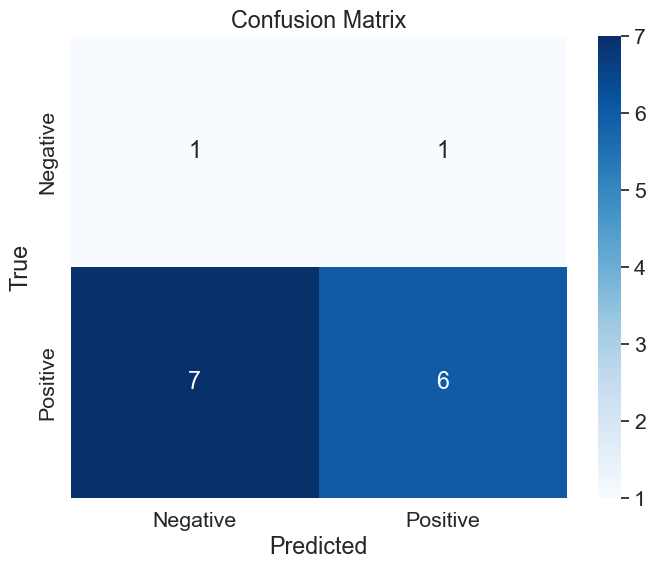

ENJBRL 


Pred proft %: 1.0019994443093994
Gamble proft %: 1.0010407560272934
True proft %: 1.0042277484822972

Look Back: 11 / Total Loss: 7611477.797657142 / Sold Portion: 0.4 

['BTCBRL  ', 'LastPrice: 343050.0  ', 'MyGamble: 343428.54 ', 'TruePrice: 344444.0  ', 'GambleProft: 1.001', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['USDTBRL ', 'LastPrice: 5.036     ', 'MyGamble: 5.07      ', 'TruePrice: 5.042     ', 'GambleProft: 1.007', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.023     ', 'TruePrice: 0.781     ', 'GambleProft: 1.324', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.498     ', 'TruePrice: 1.31      ', 'GambleProft: 1.808', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.014     ', 'TruePrice: 0.015     ', 'GambleProft: 1.015', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel:

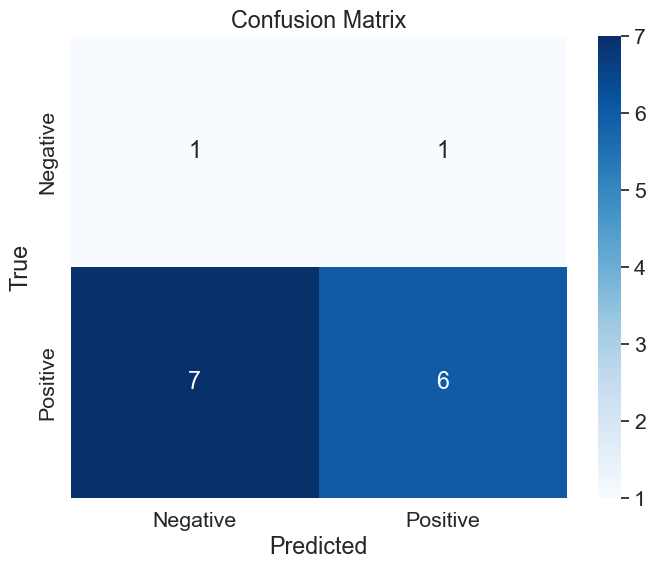

ENJBRL 


Pred proft %: 1.6346190802887919
Gamble proft %: 1.632984461208503
True proft %: 0.9710596287218427

Look Back: 11 / Total Loss: 120594724957.36984 / Sold Portion: 0.0 

['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.023     ', 'TruePrice: 0.781     ', 'GambleProft: 1.325', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.498     ', 'TruePrice: 1.31      ', 'GambleProft: 1.807', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.434', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.386', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.26666666666666666


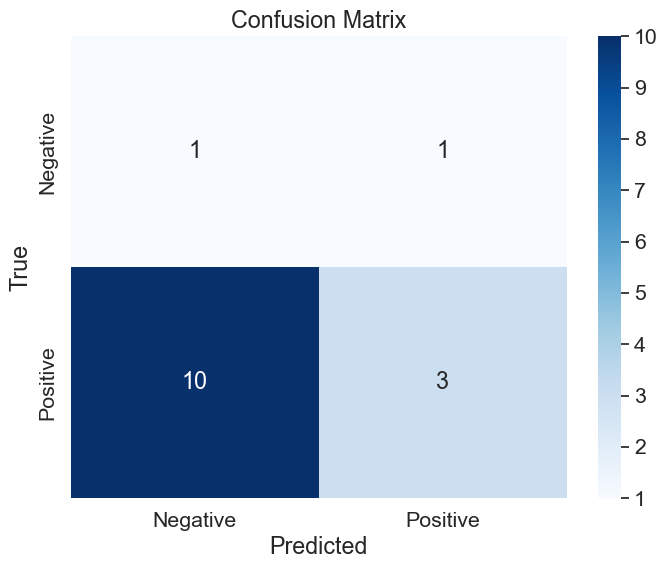

ENJBRL 



In [80]:
for i in range(3):
    pred_eval(model_10, epochs = 100, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.1925470439784778
Gamble proft %: 1.1913544969344994
True proft %: 0.99211929276621

Look Back: 11 / Total Loss: 120593693223.75493 / Sold Portion: 0.2 

['USDTBRL ', 'LastPrice: 5.036     ', 'MyGamble: 5.042     ', 'TruePrice: 5.042     ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.024     ', 'TruePrice: 0.781     ', 'GambleProft: 1.325', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.498     ', 'TruePrice: 1.31      ', 'GambleProft: 1.807', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.398', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.495', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM ac

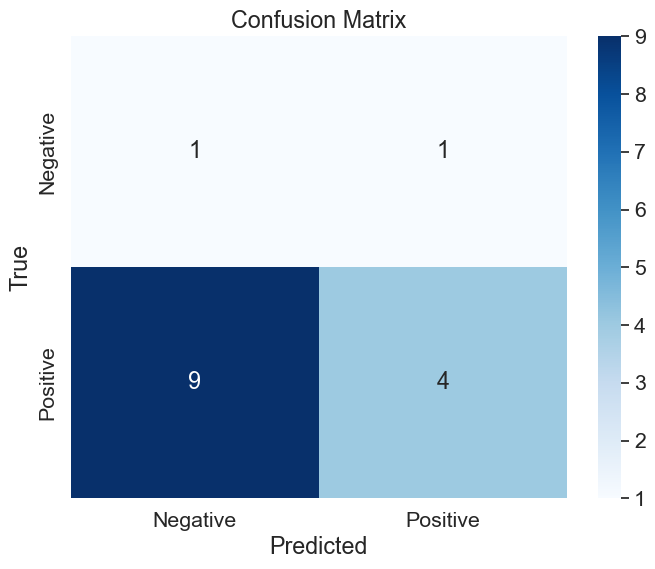

ENJBRL 


Pred proft %: 1.753063375139166
Gamble proft %: 1.751310311764027
True proft %: 0.9490495908259233

Look Back: 11 / Total Loss: 120593492514.03534 / Sold Portion: 0.0 

['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.426     ', 'TruePrice: 1.31      ', 'GambleProft: 1.755', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.384', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.323', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.2


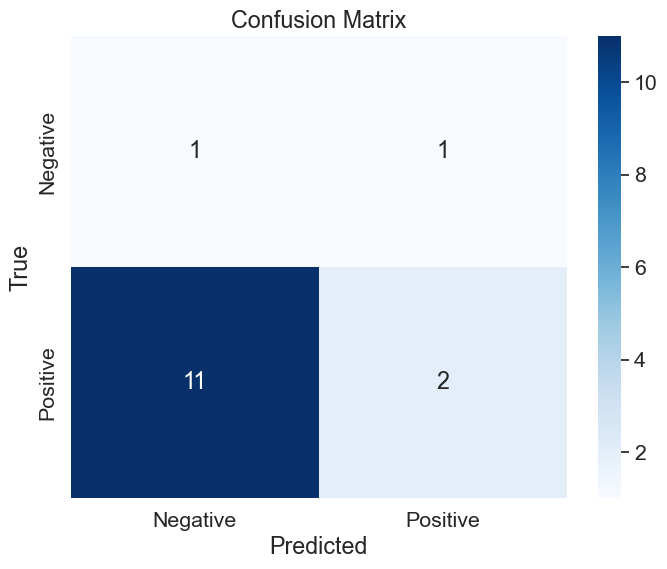

ENJBRL 


Pred proft %: 1.635308036658712
Gamble proft %: 1.6336727286220531
True proft %: 0.9710596287218427

Look Back: 11 / Total Loss: 120211158096.67813 / Sold Portion: 0.0 

['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.024     ', 'TruePrice: 0.781     ', 'GambleProft: 1.326', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.499     ', 'TruePrice: 1.31      ', 'GambleProft: 1.808', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.423', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.146', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.26666666666666666


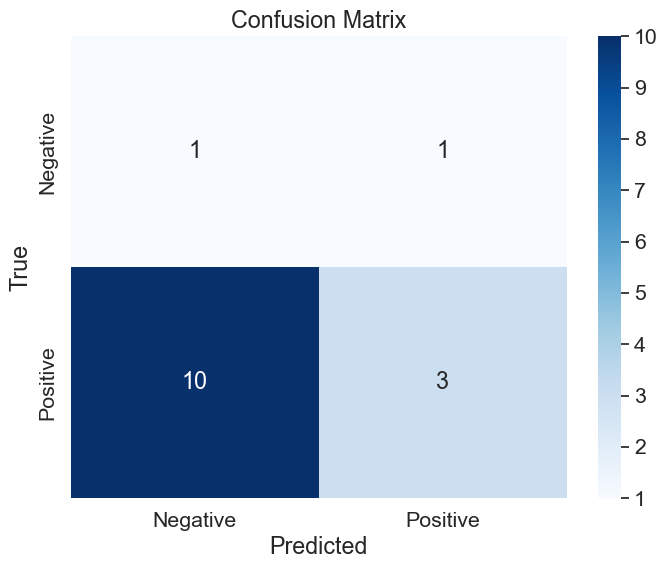

ENJBRL 



In [81]:
for i in range(3):
    pred_eval(model_11, epochs = 100, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.6359664001226712
Gamble proft %: 1.6343304337225486
True proft %: 0.9710596287218427

Look Back: 11 / Total Loss: 120211009011.50108 / Sold Portion: 0.0 

['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.025     ', 'TruePrice: 0.781     ', 'GambleProft: 1.327', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.499     ', 'TruePrice: 1.31      ', 'GambleProft: 1.808', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.021     ', 'TruePrice: 0.015     ', 'GambleProft: 1.459', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.375', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.26666666666666666


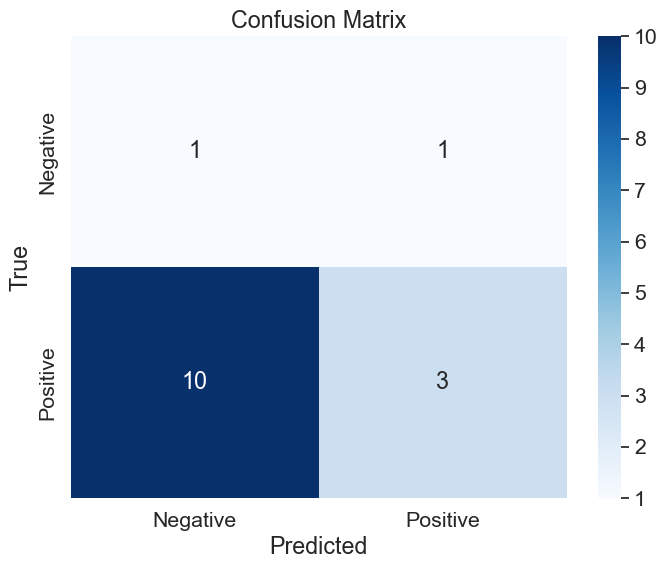

ENJBRL 


Pred proft %: 1.6343185547753045
Gamble proft %: 1.6326842362205292
True proft %: 0.9710596287218427

Look Back: 11 / Total Loss: 120593680401.03012 / Sold Portion: 0.0 

['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.024     ', 'TruePrice: 0.781     ', 'GambleProft: 1.326', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.496     ', 'TruePrice: 1.31      ', 'GambleProft: 1.806', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.415', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001     ', 'MyGamble: 0.001     ', 'TruePrice: 0.001     ', 'GambleProft: 1.195', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.26666666666666666


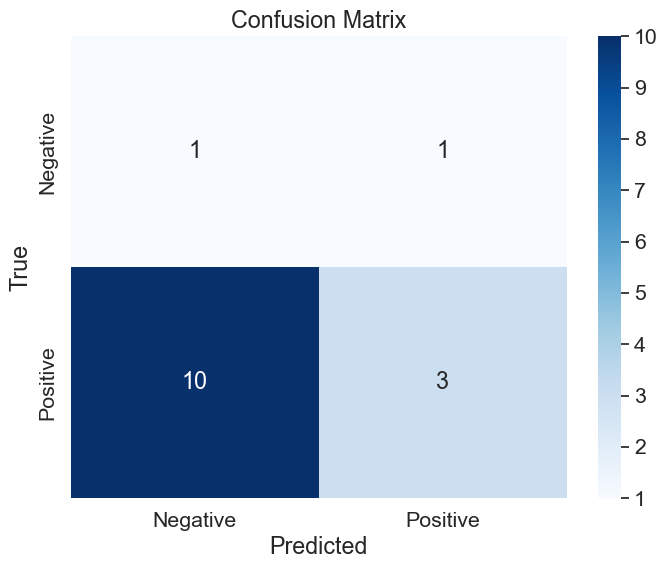

ENJBRL 


Pred proft %: 1.6354860806140574
Gamble proft %: 1.6338505945334432
True proft %: 0.9710434325453555

Look Back: 11 / Total Loss: 120593689708.93488 / Sold Portion: 0.0 

['CHZBRL  ', 'LastPrice: 0.772     ', 'MyGamble: 1.022     ', 'TruePrice: 0.781     ', 'GambleProft: 1.323', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382     ', 'MyGamble: 2.501     ', 'TruePrice: 1.31      ', 'GambleProft: 1.809', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.014     ', 'MyGamble: 0.02      ', 'TruePrice: 0.015     ', 'GambleProft: 1.434', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.2


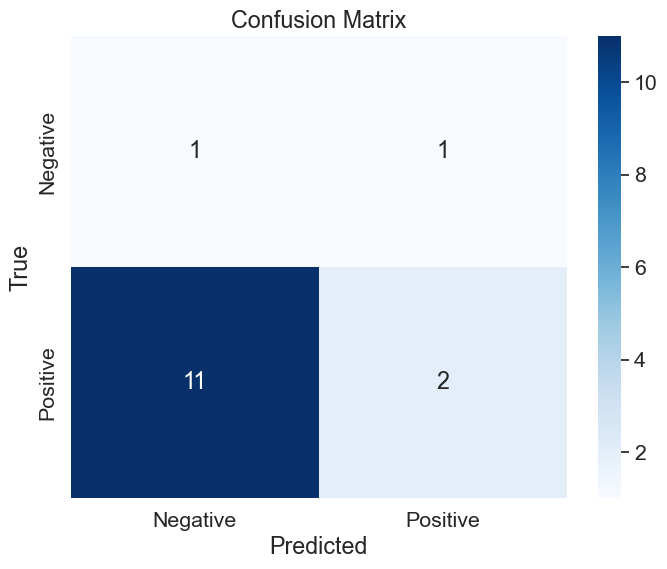

ENJBRL 



In [82]:
for i in range(3):
    pred_eval(model_12, epochs = 100, lb_list = [11], ticker_list = symbols[:15], print_info = False)

# Make a dataframe and save results

In [70]:
import threading
import multiprocessing
import os

# Function to execute in threads or processes
def your_function():
    pred_eval(model_1, epochs = 5000, lb_list = [11], ticker_list = symbols[:3])

def run_multithreading():
    num_threads = os.cpu_count()  # Use all available CPU cores
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=your_function)
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()

def run_multiprocessing():
    num_processes = os.cpu_count()  # Use all available CPU cores
    processes = []
    for _ in range(num_processes):
        process = multiprocessing.Process(target=your_function)
        process.start()
        processes.append(process)
    for process in processes:
        process.join()
        
your_function()

KeyboardInterrupt: 

In [ ]:
#csv_file = df.to_csv(f"Prediction_{present_day}.csv",index=False)

In [ ]:
dic = {"Ticker":[],"Act":[],"LastPrice":[],"Pred1":[],"Pred2":[]}
for ticker, status, last_price, pred_1, pred_2 in zip(symbols, pred_status_list, last_price_list, pred_1_list, pred_2_list):
    dic["Ticker"].append(ticker)
    dic["Act"].append(status)
    dic["LastPrice"].append(last_price)
    dic["Pred1"].append(pred_1)
    dic["Pred2"].append(pred_2)
df = pd.DataFrame(dic)
display(df)
display(df.loc[df["Act"]==True])

In [ ]:
pred_status_list, true_status_list = [], []
last_price_list = []
pred_1_list, pred_2_list = [], []
total_last_stock_price, total_pred_stock_price, total_true_stock_price = 0, 0, 0

for ticker in symbols:
    price = database[ticker]
    status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, ticker=ticker)
    pred_status_list.append(status)
    last_price_list.append(last_price)
    pred_1_list.append(pred1)
    pred_2_list.append(pred2)
    pred_proft, true_proft = pred1 - last_price, true_price1 - last_price
    if status:
        total_last_stock_price += last_price
        total_pred_stock_price += pred1
        total_true_stock_price += true_price1
    if true_proft > 0:
        true_status_list.append(True)
    if true_proft <= 0:
        true_status_list.append(False)

print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
print('\nTrue proft %:', total_true_stock_price / total_last_stock_price)
my_confusion_matrix(true_status_list, pred_status_list)

In [50]:
max_crypto = ''
min_crypto = ''
max_max_value = 0
min_max_value = 1e3
for ticker in symbols:
    price = database[ticker]
    max_value = max(price)
    if max_value > max_max_value:
        max_max_value = max_value
        max_crypto = ticker
    if max_value < min_max_value:
        min_max_value = max_value
        min_crypto = ticker
        
print('MaxCrypto:', max_crypto, max_max_value)
print('MinCrypto:', min_crypto, min_max_value)

MaxCrypto: BTCBRL 376520.0
MinCrypto: SHIBBRL 0.00044702
